# LiDAR Cone Classifier

This notebook will be used to train a basic image classifier that can distinguish between yellow traffic cones and blue traffic cones through the extracted LiDAR image crops.

* `train.ipynb`
* `data/` where all the intensity image crops are stored

The collected data are stored in:
```
data/blue
data/yellow
```

In [2]:
from __future__ import print_function, division

import os
import random

import torch
import torchvision
import PIL

from imgaug import augmenters as iaa
import imgaug as ia

import numpy as np
import matplotlib.pyplot as plt

from torch.utils import data
from torchvision import transforms, utils, datasets
from torch.utils.data import DataLoader

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

# see the device we are using
torch.cuda.get_device_name(0)

'TITAN Xp'

Load up dataset and define data augmentations.

Use third-party `ImgAug` library for more extensive image augmentation.

In [4]:
class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.Grayscale(),
            iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
            iaa.Fliplr(0.5),
            iaa.Affine(rotate=(-20, 20), mode='symmetric'),
            iaa.Sometimes(0.25,
                          iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                     iaa.CoarseDropout(0.1, size_percent=0.5)])),
            iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
        ])
      
    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)


In [6]:
lidar_dataset = datasets.ImageFolder(
    root = 'data', 
    transform = transforms.Compose([
        ImgAugTransform(),
        lambda x: PIL.Image.fromarray(x),
        transforms.Grayscale(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])
)

lidar_loader = DataLoader(lidar_dataset, batch_size = 8, shuffle = True)

In [33]:
def imshow(img):
    '''Utility function to show the loaded images'''
    npimg = img.numpy()
    plt.figure(figsize=(16,2))
    plt.imshow( np.transpose(npimg, (1, 2, 0)) )
    plt.show()
    
def imshow2(img):
    '''
    Utility function to show the loaded images
    This version does not transpose the channels.
    '''
    npimg = img.numpy()
    plt.figure(figsize=(16,2))
    plt.imshow(npimg)
    plt.show()

In [34]:
classes = lidar_dataset.classes

In [35]:
dataiter = iter(lidar_loader)
images, labels = dataiter.next()

Recall that `label=0` is blue and `label=1` is yellow.

Let's have a look at some random training images and their corresponding labels.

In [36]:
images.shape

torch.Size([8, 1, 32, 32])

In [37]:
images[0].shape

torch.Size([1, 32, 32])

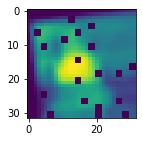

In [38]:
imshow(images[0])

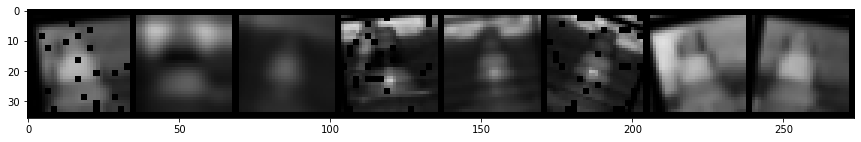

In [39]:
imshow(utils.make_grid(images))

In [41]:
labels

tensor([0, 1, 0, 1, 0, 0, 0, 0])

In [42]:
print(' '.join('%8s' % classes[labels[j]] for j in range(8)))

    blue   yellow     blue   yellow     blue     blue     blue     blue


## Split Dataset

The loaded dataset will be randomly split into `train, valid, test`.

In [43]:
def data_split(dataset, split_ratio=0.1):
    '''
    Utility function to split an existing dataset
    into train, valid, test sets.
    
    Args:
        split_ratio (float): proportion of the valid/test set
    Returns:
        tuple of subset: corresponding train, valid, test sets
    '''
    n = len(dataset)
    n_test = int( n * 0.1 ) # proportion of elements for test/val
    n_train = n - 2 * n_test

    idx = list(range(n)) # indices to all the elements
    random.shuffle(idx) # in-place shuffle the indices

    train_idx = idx[:n_train]
    val_idx   = idx[n_train:(n_train + n_test)]
    test_idx  = idx[(n_train + n_test):]

    train_set = data.Subset(dataset, train_idx)
    val_set   = data.Subset(dataset, val_idx)
    test_set  = data.Subset(dataset, test_idx)
    
    return train_set, val_set, test_set

In [44]:
train_set, valid_set, test_set = data_split(lidar_dataset, split_ratio=0.1)

Construct the corresponding dataloaders for `train, valid, test`.

In [45]:
trainloader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=2)
validloader = DataLoader(valid_set, batch_size=8, shuffle=True, num_workers=2)
testloader  = DataLoader(test_set,  batch_size=8, shuffle=True, num_workers=2)

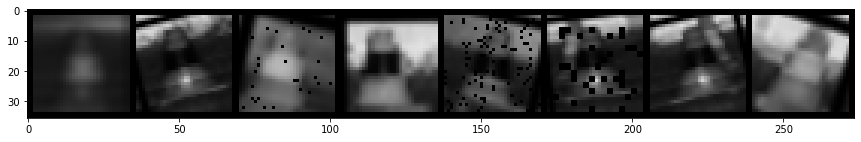

In [46]:
# get some random training images (sanity check for trainloader)
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(utils.make_grid(images))

## Define a Convolutional Neural Network

In [47]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3)
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.mp = nn.MaxPool2d(2)
        self.fc = nn.Linear(720, 2)
    
    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp(self.conv1(x)))
        x = F.relu(self.mp(self.conv2(x)))
        x = x.view(in_size, -1) # flatten tensor
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
net = Net()
net.to(device)
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=720, out_features=2, bias=True)
)


In [48]:
test_input = torch.randn(1, 1, 32, 32).to(device)
out = net(test_input)

In [49]:
out.shape

torch.Size([1, 2])

In [50]:
out

tensor([[-0.5441, -0.8684]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)

## Define loss function and optimizer

In [51]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the network

In [52]:
for epoch in range(10):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print stats
        running_loss += loss.item()
        if i % 20 == 19: ## print every 20 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

[1,    20] loss: 0.694
[1,    40] loss: 0.686
[1,    60] loss: 0.673
[1,    80] loss: 0.665
[1,   100] loss: 0.649
[2,    20] loss: 0.637
[2,    40] loss: 0.604
[2,    60] loss: 0.596
[2,    80] loss: 0.547
[2,   100] loss: 0.506
[3,    20] loss: 0.423
[3,    40] loss: 0.356
[3,    60] loss: 0.287
[3,    80] loss: 0.244
[3,   100] loss: 0.170
[4,    20] loss: 0.126
[4,    40] loss: 0.117
[4,    60] loss: 0.097
[4,    80] loss: 0.096
[4,   100] loss: 0.062
[5,    20] loss: 0.066
[5,    40] loss: 0.053
[5,    60] loss: 0.072
[5,    80] loss: 0.043
[5,   100] loss: 0.033
[6,    20] loss: 0.025
[6,    40] loss: 0.042
[6,    60] loss: 0.056
[6,    80] loss: 0.025
[6,   100] loss: 0.015
[7,    20] loss: 0.026
[7,    40] loss: 0.020
[7,    60] loss: 0.020
[7,    80] loss: 0.025
[7,   100] loss: 0.023
[8,    20] loss: 0.022
[8,    40] loss: 0.017
[8,    60] loss: 0.014
[8,    80] loss: 0.018
[8,   100] loss: 0.014
[9,    20] loss: 0.015
[9,    40] loss: 0.011
[9,    60] loss: 0.010
[9,    80] 

Save the trained model.

In [53]:
PATH = './lidar_net.pth'
torch.save(net.state_dict(), PATH)

## Test network on test data

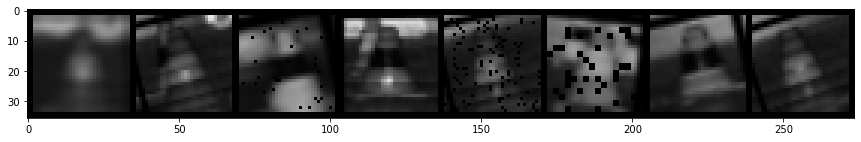

Ground truth:      blue     blue   yellow   yellow     blue     blue   yellow     blue


In [54]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# visualise the images
imshow(utils.make_grid(images))
print('Ground truth: ', ' '.join('%8s' % classes[labels[j]] for j in range(8)))

In [55]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [56]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%8s' % classes[predicted[j]] for j in range(8)))

Predicted:      blue     blue   yellow   yellow     blue     blue   yellow     blue


Let us see how the network performs on the whole test set.

In [57]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %d test images: %d %%' % (
    len(test_set),
    100 * correct / total))

Accuracy of the network on the 107 test images: 100 %


Let us see what worked well, and what did not work well.

In [58]:
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of  blue : 100 %
Accuracy of yellow : 100 %
